In [119]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv
import pandas as pd

nbAgg


In [319]:
dataset_location = 'C:/Users/sushl/Desktop/papers/datasets/data_odometry_gray/dataset/sequences/06/image_0'
L = os.listdir(dataset_location)
k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])
L.sort()   
ground_truth = np.loadtxt('C:/Users/sushl/Desktop/papers/datasets/data_odometry_poses/dataset/poses/06.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:10,3]
gz = ground_truth[:10,11]

In [320]:
def feature_detection(img,detector):
    if detector == "Fast":
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        fast = cv.FastFeatureDetector_create()
        fast.setThreshold(40)
        #print(fast.getThreshold())
        kp = fast.detect(img,None)
        orb = cv.ORB_create()
        kp, des = orb.compute(img, kp)
        
    if detector == "Orb":
        # Initiate ORB detector
        orb = cv.ORB_create()
        # find the keypoints with ORB
        kp = orb.detect(img,None)
        # compute the descriptors with ORB
        kp, des = orb.compute(img, kp)
    if detector == "Sift":
        sift = cv.SIFT_create()
        kp, des = sift.detectAndCompute(img,None)
    # draw only keypoints location,not size and orientation
    #img2 = cv.drawKeypoints(img, kp, None, color=(0,255,0), flags=0)
    #plt.imshow(img2), plt.show()
    return kp,des

In [321]:
def Triangulation(P1, P2, pts1, pts2):
    point_cloud = cv.triangulatePoints(P1, P2, pts1, pts2)
    point_cloud = point_cloud / point_cloud[3,:]
    return point_cloud.T

In [322]:
def projection_matrix(k,R,t):
    Rt = np.zeros((3,4))
    Rt[:3,:3] = R
    Rt[:,3] = t.reshape((3))
    P = k@Rt
    return P

In [323]:
def keypoint_matches(kp1,des1,kp2,des2):
    bf = cv.BFMatcher()
    pts1 = cv.KeyPoint_convert(kp1)
    pts2 = cv.KeyPoint_convert(kp2)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    common_des1 = np.array([ des1[m.queryIdx] for m in good ])
    common_des2 = np.array([ des2[m.trainIdx] for m in good ])
    common_pts1 = np.float32(src_p)
    common_pts2 = np.float32(dst_p)
    return pts1,pts2,common_pts1,common_pts2,common_des1,common_des2

In [324]:
def optical_flow_matches(imgb,imga,kpa):
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 5,
                      criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
    kpb, st, err = cv.calcOpticalFlowPyrLK(imga, imgb, kpa, None, **lk_params)
    ptsb = kpb[st == 1]
    ptsa = kpa[st == 1]
    return ptsa.reshape(-1,1,2),ptsb.reshape(-1,1,2),st

In [325]:
def pnp(p3d,pts,k):
    retval, rvec, t, inliers = cv.solvePnPRansac(p3d,pts, k, (0,0,0,0),useExtrinsicGuess = True ,iterationsCount = 100,reprojectionError = 5.0,confidence = 0.750,flags = cv.SOLVEPNP_ITERATIVE)
    R,Jec = cv.Rodrigues(rvec)
    return R,t

In [326]:
def reprojection_error(p3d,P,pts):
    proj_pt = P@p3d.T
    proj_pt = proj_pt.T
    proj_pt= proj_pt / proj_pt[:,2].reshape((-1,1))
    proj_pt = proj_pt[:,:2]
    err = proj_pt - pts.reshape((-1,2))
    err = np.linalg.norm(err)
    err = err/len(pts)
    return err

In [327]:
def refine(data,batch_size,k):
    
    final_pointcloud = np.zeros(data[-1][0].shape)
    weight_sum = 0
    for i in range(2,batch_size+1):
        final_pointcloud = final_pointcloud + data[-1*i][0]/data[-1*i][6]
        weight_sum = weight_sum + 1/data[-1*i][6]
    final_pointcloud = final_pointcloud/weight_sum
    #print("checking all point_clouds")
    for i in range(1,batch_size+1):
        #print("point_cloud difference")
        #print(len(data)-1*i , np.linalg.norm(final_pointcloud - data[-1*i][0])/len(data[-1*i][0]))
        #print(len(final_pointcloud[:,:3]),len(data[-1*i][2]))
        R,t = pnp(final_pointcloud[:,:3],data[-1*i][2],k)
        data[-1*i][1] = projection_matrix(k,R,t)
        data[-1*i][4] = cv.Rodrigues((cv.Rodrigues(R)[0]*0.5 + cv.Rodrigues(data[-1*i][4])[0]*0.5))[0]
        data[-1*i][5] = (t*0.5 + data[-1*i][5]*0.5)
        old_error = data[-1*i][6]
        data[-1*i][6] = reprojection_error(final_pointcloud,data[-1*i][1],data[-1*i][2])*0.5 + data[-1*i][6]*0.5
        #print("refined projection error")
        print(len(data)-1*i,old_error,data[-1*i][6])
    return data

In [335]:
#list containing point_cloud,projection_matrix,keypoints,descriptors,rotation and translation with respect to global reference frame.
data = []
i= 0
count = 0
while(i < 10):
    if(i == 0):
        print(":)")
        img1 = cv.imread(dataset_location +'/'+ L[i],cv.IMREAD_GRAYSCALE)
        kp1,des1 = feature_detection(img1,"Fast")
        img2 = cv.imread(dataset_location +'/'+ L[i+1],cv.IMREAD_GRAYSCALE)
        kp2,des2 = feature_detection(img1,"Fast") 
        pts1,pts2,common_pts1,common_pts2,common_des1,common_des2 = keypoint_matches(kp1,des1,kp2,des2)
        F,mask = cv.findFundamentalMat(common_pts1, common_pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
        E = k.T@F@k
        retval, R12, t12, mask = cv.recoverPose(E, common_pts1, common_pts2, k)
        R = R12
        t = t12
        #print(R,t)
        P1 = projection_matrix(k,np.eye(3).astype(np.float32),np.zeros((3,1)))
        P2 = projection_matrix(k,R,t)
        p3d = Triangulation(P1, P2, common_pts1, common_pts2)
        #print(i,reprojection_error(p3d,P1,common_pts1))
        #print(i+1,reprojection_error(p3d,P2,common_pts2))
        data.append([p3d,P1,common_pts1,common_des1,np.eye(3).astype(np.float32),np.zeros((3,1)),0.01])
        data.append([p3d,P2,common_pts2,common_des2,R,t,0.01])
        i = i+2
        count = 2
    else:
        img3 = cv.imread(dataset_location +'/'+ L[i],cv.IMREAD_GRAYSCALE)
        pts2,pts3,st = optical_flow_matches(img3,img2,data[-1][2])
        count = count +1
        if(len(data) < 5):    
            for j in range(len(data)):
                data[j][2] = data[j][2][np.where(st == 1)[0]]
                data[j][3] = data[j][3][np.where(st == 1)[0]]
                data[j][0] = data[j][0][np.where(st == 1)[0]]
        else:
            for j in range(len(data)):
                data[-1*j][2] = data[-1*j][2][np.where(st == 1)[0]]
                data[-1*j][3] = data[-1*j][3][np.where(st == 1)[0]]
                data[-1*j][0] = data[-1*j][0][np.where(st == 1)[0]]

        R,t = pnp(data[-1][0][:,:3],pts3,k)
        P3 = projection_matrix(k,R,t)
        p3d = Triangulation(P2, P3, data[-1][2],pts3)
        #print("projection error")
        #print(i,reprojection_error(p3d,P3,pts3),len(p3d))
        #if(reprojection_error(p3d,P3,pts3) < 5):
        data.append([p3d,P3,pts3,data[-1][3],R,t,reprojection_error(p3d,P3,pts3)])
        img2 = img3
        #data = refine(data,len(data),k)
        i = i+1

:)


In [336]:
data[3][6]

0.10132626690734375

In [331]:
a = np.where(st == 1)
a[0]

array([   4,    5,    9, ..., 2799, 2800, 2801], dtype=int64)

<IPython.core.display.Javascript object>


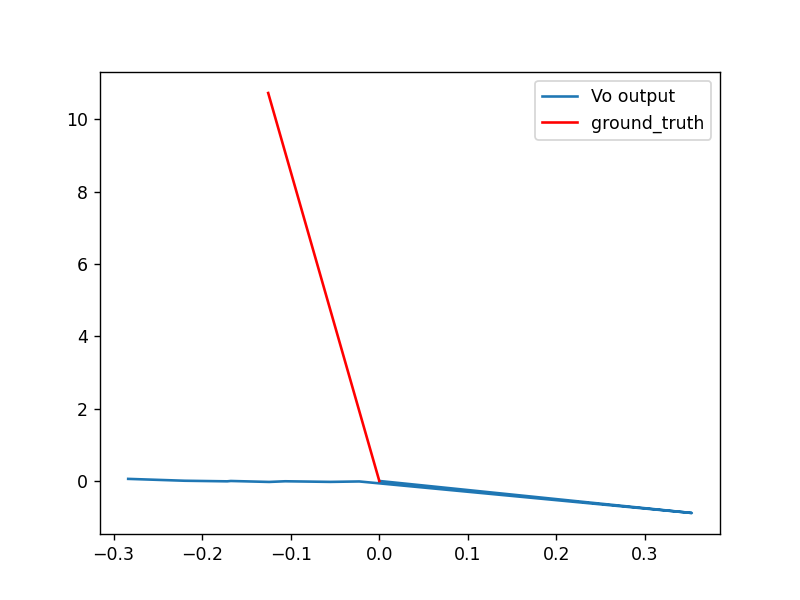

In [337]:
x0 = []
y0 = []

for i in range(len(data)):
    y0.append(data[i][5][2])
    x0.append(data[i][5][0])

fig,axes = plt.subplots()

axes.plot(x0, y0,label = 'Vo output')
axes.plot(gx, gz,color = 'red',label = 'ground_truth')
axes.legend()

plt.show()

In [162]:
else:
        img3 = cv.imread(dataset_location +'/'+ L[i],cv.IMREAD_GRAYSCALE)
        pts2,pts3,st = optical_flow_matches(img3,img2,data[-1][2])
        R,t = pnp(data[-1][0][np.where(st == 1)[0]][:,:3],pts3,k)
        P1 = projection_matrix(k,R,t)
        img1 = cv.imread(dataset_location +'/'+ L[i],cv.IMREAD_GRAYSCALE)
        kp1,des1 = feature_detection(img1,"Fast")
        img2 = cv.imread(dataset_location +'/'+ L[i+1],cv.IMREAD_GRAYSCALE)
        kp2,des2 = feature_detection(img1,"Fast") 
        pts1,pts2,common_pts1,common_pts2,common_des1,common_des2 = keypoint_matches(kp1,des1,kp2,des2)
        F,mask = cv.findFundamentalMat(common_pts1, common_pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
        E = k.T@F@k
        retval, R12, t12, mask = cv.recoverPose(E, common_pts1, common_pts2, k)
        R_total = R12@R
        t_total = t - R@t12
        P2 = projection_matrix(k,R_total,t_total)
        p3d = Triangulation(P1, P2, common_pts1, common_pts2)
        print(len(p3d))
        print(i,reprojection_error(p3d,P1,common_pts1))
        print(i+1,reprojection_error(p3d,P2,common_pts2))
        data.append([p3d,P1,common_pts1,common_des1,R,t])
        data.append([p3d,P2,common_pts2,common_des2,R_total,t_total])
        i = i+2
        count = 2

SyntaxError: invalid syntax (<ipython-input-162-23b37893ab62>, line 1)